In [6]:
!pip install yfinance 
!pip install xgboost


Error processing line 7 of C:\Users\118201\AppData\Local\Continuum\anaconda3\lib\site-packages\pywin32.pth:

  Traceback (most recent call last):
    File "C:\Users\118201\AppData\Local\Continuum\anaconda3\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named 'pywin32_bootstrap'

Remainder of file ignored


In [7]:

import yfinance as yf
import datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

date = datetime.date.today()
today = str(date)
start_years = str(date.today() + relativedelta(years=-20))
stock_list = ['^GSPC', '^VIX']

# 抓取20年資料
df = yf.download(stock_list[0], start = start_years, end = today).drop(columns='Adj Close')
vix = yf.download(stock_list[1], start = start_years, end = today)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
df['VIX']=vix['Close']
df['MA10']=df['Close'].rolling(10,min_periods=1).mean()
df['MA60']=df['Close'].rolling(60,min_periods=1).mean()
df['Daily Return'] = df['Close'].pct_change()
df['VixMA']=df["VIX"].rolling(10,min_periods=1).mean()
df['VIXDiffer']=df['VIX']-df['VixMA']
df['diff']=df['Daily Return'].shift(-1)

df['VIXup']= df['VIXDiffer'].apply(lambda x: 1 if x>0 else 0)
df['Close0']=(df['Close']-df['Open'])/df['Open']
df['Vol0']=(df['Volume']-df['Volume'].rolling(10,min_periods=1).mean())/df['Volume']
df['MA10_0']=(df['Close']-df['MA10'])/df['MA10']
df['MA60_0']=(df['Close']-df['MA60'])/df['MA60']
df['Mid']=(df['Close']-df['Low'])/(df['High']-df['Low'])
df['TR']=(df['High']-df['Low'])/df['Close']
df['Open0']=df['Open']-df['Close'].shift(1)
# y


漲:  1836 
平:  1700 
跌:  1498
Accuracy: 40.68%
訓練集 Accuracy:  0.9899425287356322
測試集 Accuracy:  0.40683646112600536


C:\Users\118201\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


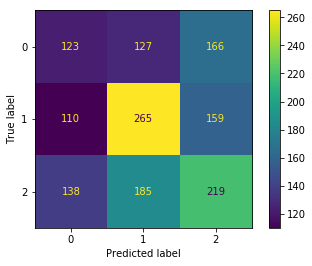

In [10]:
df['up']= df['diff'].apply(lambda x: 2 if x>0.003 else (0 if x<-0.003 else 1 ))
print('漲: ',len(df.loc[df['up'] == 2]), '\n平: ',len(df.loc[df['up'] == 1]), '\n跌: ',len(df.loc[df['up'] == 0]))

df=df[:-1]

X=df[['VIXDiffer','Close0', 'Mid','Vol0' , 'MA10_0' , 'MA60_0' , 'TR' , 'Open0']]
y=df[['up']]

X = X[61:]
y = y[61:]

#
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(booster='gbtree', objective='multi:softprob')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred )

print("Accuracy: %.2f%%" % (accuracy * 100.0))

print('訓練集 Accuracy: ',model.score(X_train,y_train))
print('測試集 Accuracy: ',model.score(X_test,y_test))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)  

ValueError: num must be 1 <= num <= 16, not 17

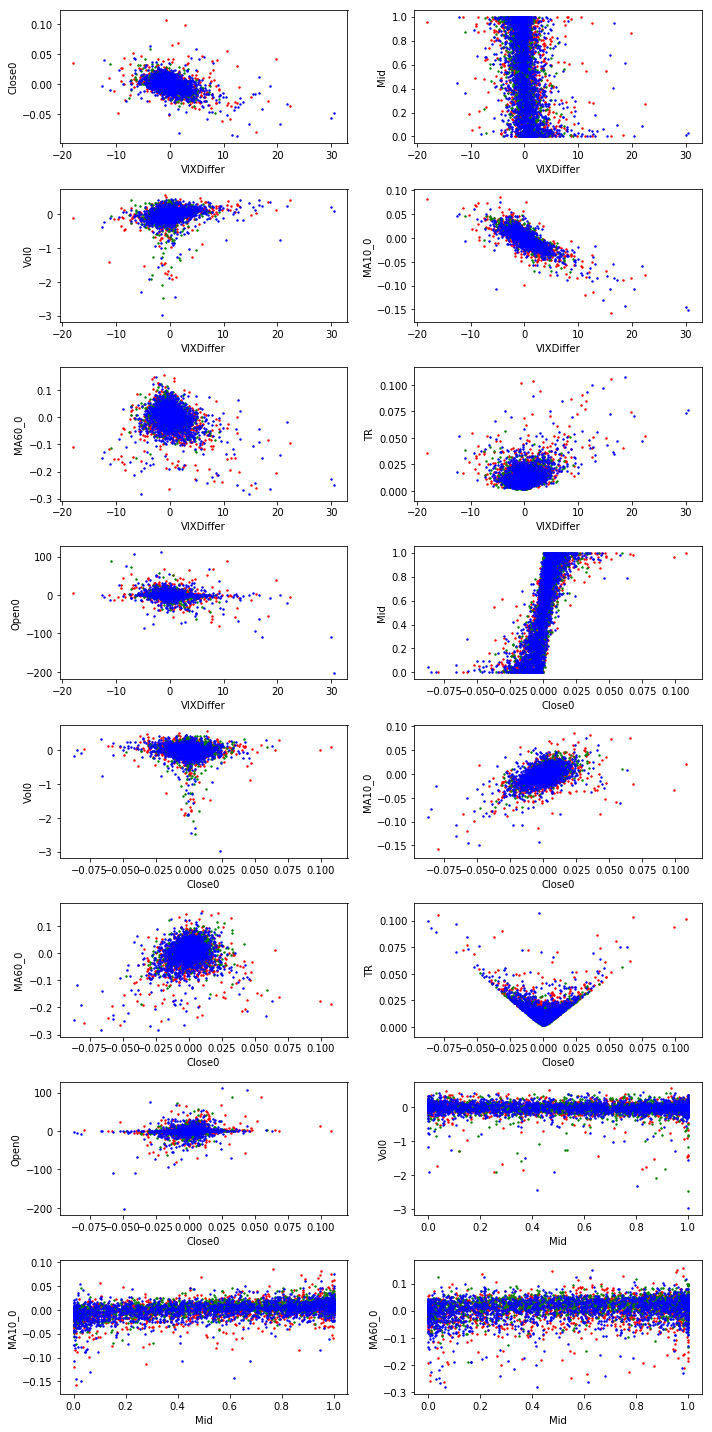

In [11]:

columns_list=list(X.columns)
count=1
plt.subplots(8, 2, figsize=(10, 20))
for i in range(len(columns_list) -1):
    for j in range(i+1, len(columns_list)):
          plt.subplot(8,2,count)
          plt.scatter(x=df.loc[df['up'] == 0][columns_list[i]] , y=df.loc[df['up']==0][columns_list[j]], label='0'
                       ,s=2,color='r')
          plt.scatter(x=df.loc[df['up'] == 1][columns_list[i]] , y=df.loc[df['up']==1][columns_list[j]], label='1'
                       ,s=2,color='g')
          plt.scatter(x=df.loc[df['up'] == 2][columns_list[i]] , y=df.loc[df['up']==2][columns_list[j]], label='2'
                       ,s=2,color='b')
          plt.xlabel(columns_list[i])
          plt.ylabel(columns_list[j])
          plt.tight_layout()
          count+=1